<a href="https://colab.research.google.com/github/Rdeandres/Game_Analytics_Classification/blob/main/Fitting_BG_NBD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accesing the Data in Player Warehouse
This is real data, need to change for dummy data!!!!

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [3]:
#Connecting to Google Big Query
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [4]:
#Replace 'project_id' with your BigQuery project ID
from google.cloud import bigquery
client = bigquery.Client(project='ga-looker-5add7883')

In [5]:
#Replace 'dataset_name' with your actual dataset name
#Replace 'table_name' with the name of the table you want to query
sql_query = ('''SELECT *
                FROM ga_looker_5add7883_checkpoints.player_checkpoint
                LIMIT 10''')
df = client.query(sql_query).to_dataframe()
print(df)

   checkpoint  game_id                               user_id  \
0  2022-02-03   148183  26495530-3E48-4258-95EF-DDEFDCBA61EE   
1  2022-02-03   148183  215ADBA6-237F-4C29-994A-7DF032945316   
2  2022-02-03   148183  CC1F5BEB-0E30-47F8-8341-F7E8D5139191   
3  2022-02-03   148183  7EB3B5A8-3232-42AA-A196-DB5412EF861A   
4  2022-02-03   148183  25E80346-E2AA-430D-BF7A-F58DE40A3A3C   
5  2022-02-03   148183  897E5DF0-D3DE-4B1F-8EF1-79082214797D   
6  2022-02-03   148183  B2AC1459-9454-48BD-9B3A-A9447132D183   
7  2022-02-03   148183  58AC5375-76C7-4621-93AC-00DABF8FB8F8   
8  2022-02-03   148183  BE254906-8C1E-4872-92DA-B9063844E164   
9  2022-02-03   148183  17E8AFF6-D505-4561-86BA-CE85885C98BC   

                          player_id  event_count is_paying is_paying_today  \
0  0f771a6cfbfe4672e32f1b8e8314b3bb           55      None            None   
1  b43f66f248990f08950db95101033cfd           28      None            None   
2  8ae129c4b4917a7886700c461dbddb40           65      None   

# Structuring RFM values for the game

In [13]:
#need to select by game id 

#country_code can be added 

sql_query = ('''

                SELECT 
                player_id,
                min(DATETIME (install_ts)) as subscription_date,
                max(DATETIME_DIFF(DATETIME ('2022-02-20'), DATETIME (install_ts), DAY)) as maturity,
                sum(ad_ilrd_revenue) as value,
                min(cohort_week) as subscription_bom,
                count(distinct checkpoint) as frequency,
                max(DATETIME_DIFF(DATETIME ('2022-02-20'), DATETIME (checkpoint), DAY)) as recency

                
                FROM  `ga-looker-5add7883.checkpoints.player_checkpoint`
                where checkpoint>= '2022-01-03' and checkpoint <= '2022-02-20'  and game_id=135152
                group by 1
         
                ''')
ret = client.query(sql_query).to_dataframe()
ret.head()

,player_id,subscription_date,maturity,value,subscription_bom,frequency,recency
0,aa94dc1edcf15cf7cd1657d2a39d6a46,2021-05-03,293,NaN,2021-05-03,1,46
1,9036857de8ce3390cc88aa71494da714,2021-05-22,274,NaN,2021-05-17,1,46
2,68bfdd6726512e5ce1e9ca0a96af0b55,2021-05-28,268,NaN,2021-05-24,1,46
3,a687f5cbc3c0b8cfedc2c2c17c793408,2021-06-11,254,NaN,2021-06-07,1,46
4,af47205499be86153dc85813eca149d5,2021-06-25,240,NaN,2021-06-21,1,46


In [14]:
#fitting beta gamma model

import pandas as pd
import numpy as np
#!pip install lifetimes
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix
from lifetimes.generate_data import beta_geometric_nbd_model
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive



In [15]:
bgf = BetaGeoFitter()
bgf.fit(ret['frequency'], ret['recency'], ret['maturity'])

bgf.summary

NameError: ignored

In [16]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,3.036295,0.005192,3.026118,3.046472
alpha,38.524310,0.073473,38.380303,38.668318
a,0.820858,0.006558,0.808004,0.833711
b,5.006126,0.045588,4.916773,5.095479


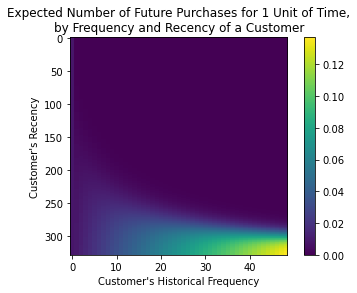

In [17]:
plot_frequency_recency_matrix(bgf)

In [18]:
t = 1
ret['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, ret['frequency'], ret['recency'], ret['maturity'])
ret.sort_values(by='predicted_purchases').tail(5)



,player_id,subscription_date,maturity,value,subscription_bom,frequency,recency,predicted_purchases
3728168,5b594089fcdf47fec3e3909fa127983b,2022-01-07,44,46.468961,2022-01-03,40,44,0.509519
3060484,67c2e19f69c24cfaba516c1cdc657b01,2022-01-15,36,7.977379,2022-01-10,36,36,0.510590
4070316,ab815fc89c6d810140010dd43b399e56,2022-01-03,48,NaN,2022-01-03,43,48,0.520557
3070258,02b55b13aa35796a8c3d27b11e4c442a,2022-01-15,36,177.848428,2022-01-10,37,36,0.523924
3291453,2dcb7cc9a8f9f98eb1cc651a9abb3b93,2022-01-11,40,44.306862,2022-01-10,41,40,0.548005


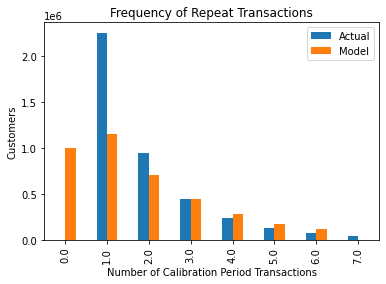

In [19]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

The alpha-beta-gamma model, a dictates the generation time, b sets the scale of demographic stochasticity, and c reflects environmental noise. The growth rate is fluctuating in time, at any given time the population is either decreasing or increasing deterministically. The parameter c(t) defines the instantaneous growth rate of a population (or its relative fitness) at time t and so characterizes the environmental stochasticity. The parameter c(t) is picked independently for every period of time and every species, from a distribution of zero mean and variance D. Between censuses a tree may remain inactive with probability a. If it is active, it dies with probability b or produces (1 þ c)/b offspring.